<a href="https://colab.research.google.com/github/Shobhit2000/Neural-Style-Transfer/blob/master/Neural_Style_Tranfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


**Preprocess image according to the input format of the VGG16 network**

In [0]:
def preprocess(img):

    img = np.asarray(img,dtype='float32')
    img = np.expand_dims(img, axis=0)
    img[:, :, :, 0] -= 103.939
    img[:, :, :, 1] -= 116.779
    img[:, :, :, 2] -= 123.68
    img = img[:, :, :, ::-1]
    return img

In [0]:
# from google.colab import files
# files.upload()

**Load, resize and call preprocess function**

In [0]:
content_img = Image.open('content.jpg')
content_img = content_img.resize((512,512))
content_img = preprocess(content_img)

style_img= Image.open('style.png')
style_img = style_img.resize((512,512))
style_img = preprocess(style_img)

In [5]:
print(content_img.shape)
print(style_img.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


**Declare the required VGG16 layers**

In [0]:
style_layers = ['block1_conv2','block2_conv2', 
                'block3_conv3','block4_conv3',
                'block5_conv3']

**Declare the tf variables and placeholders**

In [0]:
height = 512
width = 512

content_img = K.variable(content_img)
style_img = K.variable(style_img)
comb_img = K.placeholder((1, height, width, 3))

**Combine the images to be sent as input tensors**

In [0]:
input_tensor = K.concatenate([content_img, style_img, comb_img], axis=0)

**Load the VGG16 network with imagenet weights without including any dense layers**

In [0]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)

In [0]:
layer_details = dict([(layer.name, layer.output) for layer in model.layers])

**Initialize Weights**

In [0]:
# define initial weights
content_weight = 0.025
style_weight = 25.0
total_variation_weight = 1.0

# initialize initial loss variable to 0
loss_val = K.variable(0.)

**Content Loss function**

In [0]:
def content_loss(content, combination):
    return K.sum(K.square(content-combination))

In [0]:
# call the content loss function
layer_features = layer_details['block2_conv2']
content_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss_val = loss_val + content_loss(content_features, combination_features) * content_weight

**Gram Matrix Function**

In [0]:
def gram_matrix(array):
    features = K.batch_flatten(K.permute_dimensions(array, (2, 0, 1)))
    matrix = K.dot(features, K.transpose(features))
    return matrix

**Style Loss Function**

In [0]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    sl = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return sl

In [0]:
# call the style loss function for every VGG16 layer
for layer in style_layers:
    
    layer_features = layer_details[layer]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss_val = loss_val + (style_weight / len(style_layers)) * sl

**Total Loss Function**

In [0]:
def total_variation_loss(x):
    a = K.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss_val = loss_val + (total_variation_weight * total_variation_loss(comb_img))

**Perform Gradient Descent**

In [0]:
grads = K.gradients(loss_val, comb_img)

In [0]:
outputs = [loss_val]

if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([comb_img], outputs)

In [0]:
def eval_loss_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [0]:
evaluator = Evaluator()

In [0]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.0

iterations = 5

In [24]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
183840870000.0
Iteration 0 completed in 6s
Start of iteration 1
83137690000.0
Iteration 1 completed in 4s
Start of iteration 2
61141480000.0
Iteration 2 completed in 4s
Start of iteration 3
51505310000.0
Iteration 3 completed in 4s
Start of iteration 4
46181605000.0
Iteration 4 completed in 4s


In [0]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

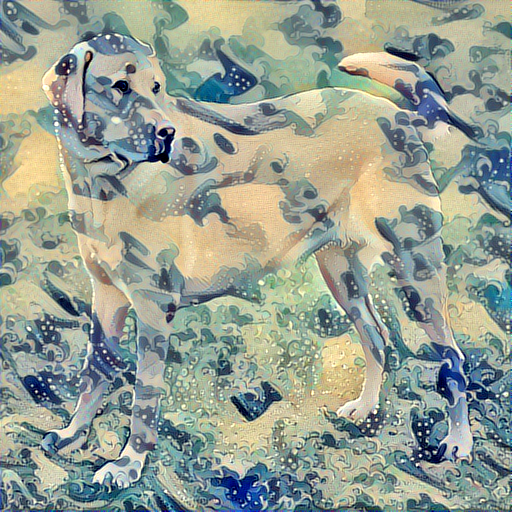

In [26]:
Image.fromarray(x)